In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # For splitting LSTM data
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler # For LSTM
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb
import torch
import torch.nn as nn
import torch.utils.data 
import torch.optim as optim
import pickle
import os
from matplotlib import pyplot as plt



### GSPC + Random Forest

In [2]:
df = pd.read_csv('../data/sp500_stock_prices_2000_2025.csv', index_col='Date', parse_dates=True, skiprows=[1]).drop(columns=['Adj Close', 'Volume', 'High', 'Low','Open'])
INPUT_FEATURES = [f'Close_lag_{i}' for i in range(1, 14 + 1)] +[f'{'Close'}_pct_change_1d']
TARGET_COLUMN = 'Close'
df['target_pct_change'] = df[TARGET_COLUMN].pct_change().shift(-1)
df.dropna(inplace=True)

In [3]:
# 1. Create Lag Features
LAG_DAYS = 14
target_col = 'Close'
for i in range(1, LAG_DAYS + 1):
    feature_name = f'{target_col}_lag_{i}'
    df[feature_name] = df[target_col].shift(i)

# 2. Create Percentage Change Feature
# (Today's target_col - Yesterday's target_col) / Yesterday's target_col
df['Close_pct_change_1d'] = df[target_col].pct_change()

# 3. Create 'close_target' (next day's target_col value)
df['close_target'] = df[target_col].shift(-1)

# 4. Drop rows with NaNs created by shifting (for lags, pct_change, and close_target)
df.dropna(inplace=True)

In [4]:
INPUT_FEATURES

['Close_lag_1',
 'Close_lag_2',
 'Close_lag_3',
 'Close_lag_4',
 'Close_lag_5',
 'Close_lag_6',
 'Close_lag_7',
 'Close_lag_8',
 'Close_lag_9',
 'Close_lag_10',
 'Close_lag_11',
 'Close_lag_12',
 'Close_lag_13',
 'Close_lag_14',
 'Close_pct_change_1d']

In [5]:
X_trad = df[INPUT_FEATURES].copy()
y_trad = df['target_pct_change'].copy()
split_idx_trad = int(len(X_trad) * 0.8)
X_train_trad, X_test_trad = X_trad.iloc[:split_idx_trad], X_trad.iloc[split_idx_trad:]
y_train_trad, y_test_trad = y_trad.iloc[:split_idx_trad], y_trad.iloc[split_idx_trad:]


In [6]:
param_grid_rf = {
        'n_estimators': [100, 150, 200 ,300],
        'max_depth': [15, 20, 12,None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 1.0],
        'random_state': [42,43,44],
    }

rf = RandomForestRegressor(n_jobs=-1)


In [7]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


time_series_cv = TimeSeriesSplit(n_splits=10, gap=0)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                                  cv=time_series_cv, # SỬ DỤNG TimeSeriesSplit Ở ĐÂY
                                  scoring='neg_mean_squared_error',
                                  verbose=2,
                                  n_jobs=-1)

In [8]:
grid_search_rf.fit(X_train_trad, y_train_trad)

Fitting 10 folds for each of 864 candidates, totalling 8640 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 12, None],
                         'max_features': ['sqrt', 1.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200, 300],
                         'random_state': [42, 43, 44]},
             scoring='neg_mean_squared_error', verbose=2)

In [9]:
best_params = grid_search_rf.best_params_
print(f"\nBest parameters found for RandomForest: {best_params}")
print(f"Best cross-validation score (Negative MSE with TimeSeriesSplit): {grid_search_rf.best_score_}")


Best parameters found for RandomForest: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 44}
Best cross-validation score (Negative MSE with TimeSeriesSplit): -0.00016123744502275815


In [11]:
# model = RandomForestRegressor(**{'max_depth': 12, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}, random_state=42, n_jobs=-1)
model = RandomForestRegressor(**best_params, n_jobs=-1)
model.fit(X_train_trad, y_train_trad)
y_pred_pct_change_test = model.predict(X_test_trad)

In [12]:
last_actual_close_for_test_samples = df.loc[X_test_trad.index, TARGET_COLUMN]
y_test_absolute_actual = df.loc[X_test_trad.index, 'close_target']
y_pred_absolute_test = last_actual_close_for_test_samples * (1 + y_pred_pct_change_test)


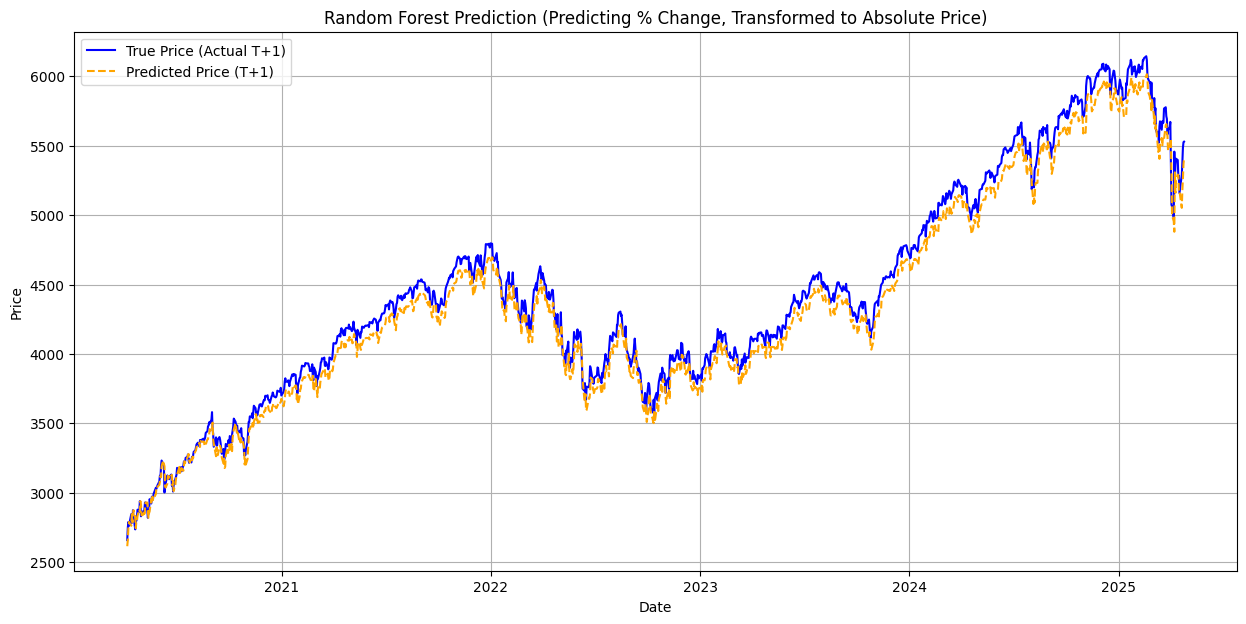

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(y_test_absolute_actual.index, y_test_absolute_actual, label='True Price (Actual T+1)', color='blue')
plt.plot(y_test_absolute_actual.index, y_pred_absolute_test, label='Predicted Price (T+1)', color='orange', linestyle='--')
plt.title('Random Forest Prediction (Predicting % Change, Transformed to Absolute Price)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### GSPC + XGBoost

In [18]:
param_grid_xgb = {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.001, 0.005, 0.01, 0.05],
        'max_depth': [8, 10, 12, 15],
        'gamma': [0, 0.1, 0.2],
        'random_state': [42, 43, 44],
        'reg_alpha': [0, 0.01, 0.1], # L1 regularization
        'reg_lambda': [1, 0.1, 0.01] # L2 regularization
    }

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',
                               # early_stopping_rounds can't be directly used with scikit-learn GridSearchCV
                               # It's handled by XGBoost's fit method if eval_set is provided there.
                               # For GridSearchCV, we rely on CV scores.
                               tree_method='hist' # Often faster for larger datasets
                               )

grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=param_grid_xgb,
                                   cv=10,
                                   scoring='neg_mean_squared_error',
                                   verbose=2,
                                   n_jobs=-1)

In [19]:
grid_search_xgb.fit(X_train_trad, y_train_trad)

Fitting 10 folds for each of 5184 candidates, totalling 51840 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=Non...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.001, 0.005, 0.01, 0.05],
                         'max_depth': [8, 10, 12, 15],
                         'n_estimators': [100, 200, 300, 400],
                         'random_state': [42, 43, 44],
                         'reg_alpha': [0, 0.01, 0.1],
                         'reg_lambda': [1, 0.1, 0.01]},
             scoring='neg_mean_squared_error', verbose=2)

In [20]:
best_params_xgb = grid_search_xgb.best_params_
print(f"\nBest parameters found for XGBoost: {best_params_xgb}")
print(f"Best cross-validation score (Negative MSE with TimeSeriesSplit): {grid_search_xgb.best_score_}")


Best parameters found for XGBoost: {'gamma': 0, 'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 1}
Best cross-validation score (Negative MSE with TimeSeriesSplit): -0.00015570363847237025


In [22]:
model = xgb.XGBRegressor(**best_params_xgb, objective='reg:squarederror',
                               tree_method='hist')
model.fit(X_train_trad, y_train_trad)
y_pred = model.predict(X_test_trad)

In [23]:
last_actual_close_for_test_samples = df.loc[X_test_trad.index, TARGET_COLUMN]
y_test_absolute_actual = df.loc[X_test_trad.index, 'close_target']
y_pred_absolute_test = last_actual_close_for_test_samples * (1 + y_pred)

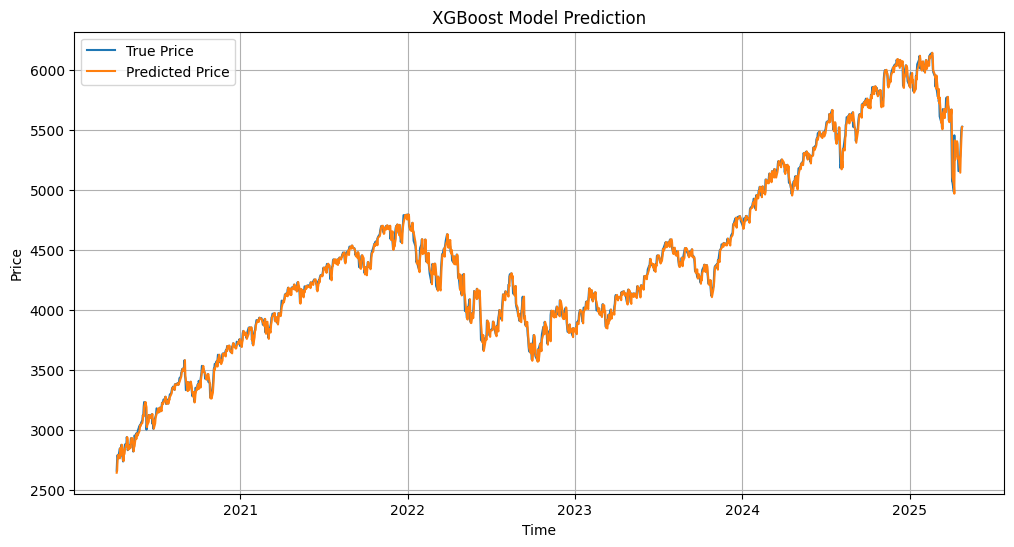

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_absolute_actual, label='True Price')
plt.plot(y_pred_absolute_test, label='Predicted Price')
plt.title('XGBoost Model Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### IBM + Random Forest

In [25]:
df = pd.read_csv('../data/ibm_stock_prices_2000_2025.csv', index_col='Date', parse_dates=True, skiprows=[1]).drop(columns=['Adj Close', 'Volume', 'High', 'Low','Open'])
INPUT_FEATURES = [f'Close_lag_{i}' for i in range(1, 14 + 1)] +[f'{'Close'}_pct_change_1d']
TARGET_COLUMN = 'Close'
df['target_pct_change'] = df[TARGET_COLUMN].pct_change().shift(-1)
df.dropna(inplace=True)

In [26]:
# 1. Create Lag Features
LAG_DAYS = 14
target_col = 'Close'
for i in range(1, LAG_DAYS + 1):
    feature_name = f'{target_col}_lag_{i}'
    df[feature_name] = df[target_col].shift(i)

# 2. Create Percentage Change Feature
# (Today's target_col - Yesterday's target_col) / Yesterday's target_col
df['Close_pct_change_1d'] = df[target_col].pct_change()

# 3. Create 'close_target' (next day's target_col value)
df['close_target'] = df[target_col].shift(-1)

# 4. Drop rows with NaNs created by shifting (for lags, pct_change, and close_target)
df.dropna(inplace=True)

In [27]:
X_trad = df[INPUT_FEATURES].copy()
y_trad = df['target_pct_change'].copy()
split_idx_trad = int(len(X_trad) * 0.8)
X_train_trad, X_test_trad = X_trad.iloc[:split_idx_trad], X_trad.iloc[split_idx_trad:]
y_train_trad, y_test_trad = y_trad.iloc[:split_idx_trad], y_trad.iloc[split_idx_trad:]


In [28]:
param_grid_rf = {
        'n_estimators': [100, 150, 200,300],
        'max_depth': [15, 20, 12,None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 1.0], # 1.0 for all features in regressor
        'random_state': [42,43,44,45],
    }

rf = RandomForestRegressor(n_jobs=-1)


In [29]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


time_series_cv = TimeSeriesSplit(n_splits=10, gap=0)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                                  cv=time_series_cv, # SỬ DỤNG TimeSeriesSplit Ở ĐÂY
                                  scoring='neg_mean_squared_error',
                                  verbose=2,
                                  n_jobs=-1)

In [30]:
grid_search_rf.fit(X_train_trad, y_train_trad)

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 12, None],
                         'max_features': ['sqrt', 1.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200, 300],
                         'random_state': [42, 43, 44, 45]},
             scoring='neg_mean_squared_error', verbose=2)

In [32]:
best_params = grid_search_rf.best_params_
print(f"\nBest parameters found for RandomForest: {best_params}")
print(f"Best cross-validation score (Negative MSE with TimeSeriesSplit): {grid_search_rf.best_score_}")


Best parameters found for RandomForest: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}
Best cross-validation score (Negative MSE with TimeSeriesSplit): -0.000263714968010366


In [33]:
# model = RandomForestRegressor(**{'max_depth': 12, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}, random_state=42, n_jobs=-1)
model = RandomForestRegressor(**best_params, n_jobs=-1)
model.fit(X_train_trad, y_train_trad)
y_pred_pct_change_test = model.predict(X_test_trad)

In [34]:
last_actual_close_for_test_samples = df.loc[X_test_trad.index, TARGET_COLUMN]
y_test_absolute_actual = df.loc[X_test_trad.index, 'close_target']
y_pred_absolute_test = last_actual_close_for_test_samples * (1 + y_pred_pct_change_test)


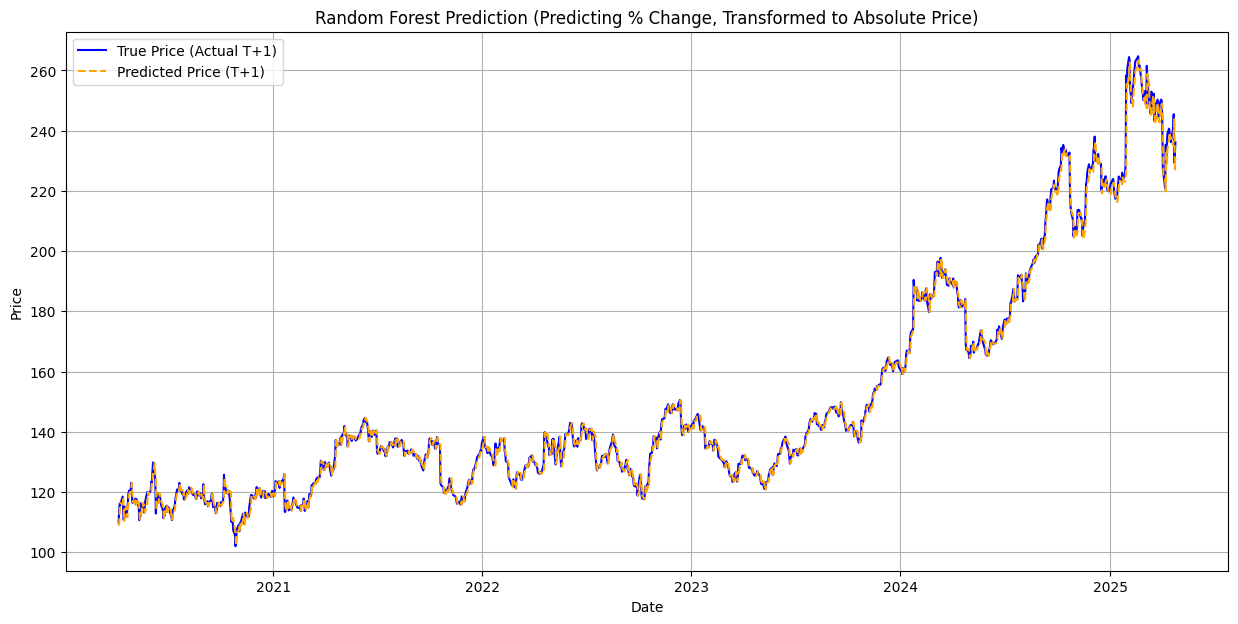

In [35]:
plt.figure(figsize=(15, 7))
plt.plot(y_test_absolute_actual.index, y_test_absolute_actual, label='True Price (Actual T+1)', color='blue')
plt.plot(y_test_absolute_actual.index, y_pred_absolute_test, label='Predicted Price (T+1)', color='orange', linestyle='--')
plt.title('Random Forest Prediction (Predicting % Change, Transformed to Absolute Price)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### IBM + XGBoost

In [37]:
param_grid_xgb = {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.001, 0.005, 0.01, 0.05],
        'max_depth': [8, 10, 12, 15],
        'gamma': [0, 0.1, 0.2],
        'random_state': [42, 43, 44],
        'reg_alpha': [0, 0.01, 0.1], # L1 regularization
        'reg_lambda': [1, 0.1, 0.01] # L2 regularization
    }

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',
                               # early_stopping_rounds can't be directly used with scikit-learn GridSearchCV
                               # It's handled by XGBoost's fit method if eval_set is provided there.
                               # For GridSearchCV, we rely on CV scores.
                               tree_method='hist' # Often faster for larger datasets
                               )

grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=param_grid_xgb,
                                   cv=time_series_cv,
                                   scoring='neg_mean_squared_error',
                                   verbose=2,
                                   n_jobs=-1)

In [38]:
grid_search_xgb.fit(X_train_trad, y_train_trad)

Fitting 10 folds for each of 5184 candidates, totalling 51840 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=Non...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.001, 0.005, 0.01, 0.05],
                         'max_depth': [8, 10, 12, 15],
                         'n_estimators': [100, 200, 300, 400],
                         'random_state': [42, 43, 44],
                         'reg_alpha': [0, 0.01, 0.1],
                         'reg_lambda': [1, 0.1, 0.01]},
             scoring='neg_mean_squared_error', verbose=2)

In [39]:
best_params_xgb = grid_search_xgb.best_params_
print(f"\nBest parameters found for XGBoost: {best_params_xgb}")
print(f"Best cross-validation score (Negative MSE with TimeSeriesSplit): {grid_search_xgb.best_score_}")


Best parameters found for XGBoost: {'gamma': 0, 'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.1}
Best cross-validation score (Negative MSE with TimeSeriesSplit): -0.0002272464820618399


In [40]:
model = xgb.XGBRegressor(**best_params_xgb, objective='reg:squarederror',
                               tree_method='hist')
model.fit(X_train_trad, y_train_trad)
y_pred = model.predict(X_test_trad)

In [41]:
last_actual_close_for_test_samples = df.loc[X_test_trad.index, TARGET_COLUMN]
y_test_absolute_actual = df.loc[X_test_trad.index, 'close_target']
y_pred_absolute_test = last_actual_close_for_test_samples * (1 + y_pred)

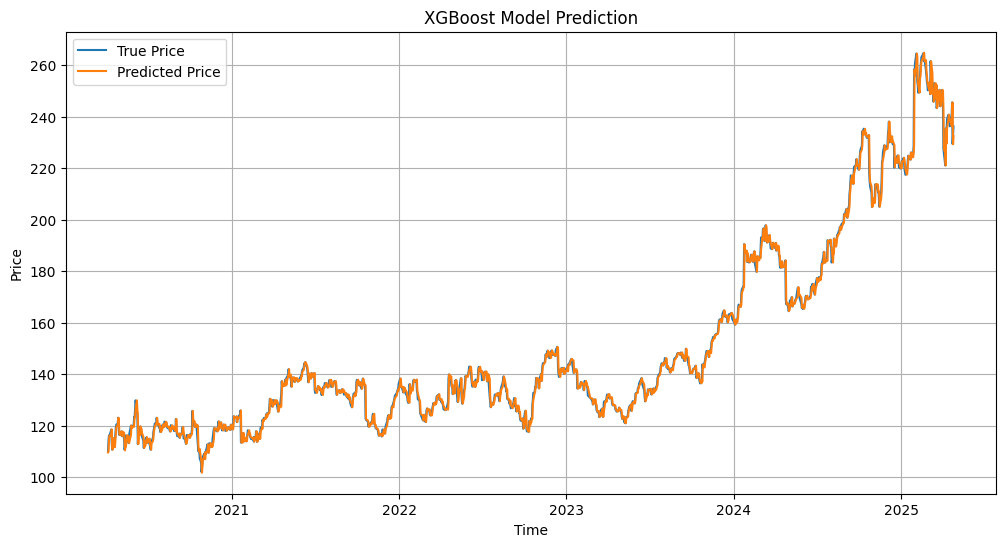

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_absolute_actual, label='True Price')
plt.plot(y_pred_absolute_test, label='Predicted Price')
plt.title('XGBoost Model Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
evaluate_model(y_test_absolute_actual, y_pred_absolute_test)

Mean Squared Error: 6.353451200716925
Mean Absolute Error: 1.5991795516110843


In [44]:
ibm_rf = RandomForestRegressor(**{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}, n_jobs=-1)
ibm_rf.fit(X_train_trad, y_train_trad)

RandomForestRegressor(max_depth=12, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_jobs=-1, random_state=42)

In [46]:
first_tree = ibm_rf.estimators_[0]

[Text(0.15247844827586207, 0.9615384615384616, 'Close_lag_14 <= 62.519\nsquared_error = 0.0\nsamples = 3207\nvalue = 0.0'),
 Text(0.04597701149425287, 0.8846153846153846, 'Close_lag_2 <= 60.87\nsquared_error = 0.002\nsamples = 15\nvalue = 0.027'),
 Text(0.09922772988505747, 0.9230769230769231, 'True  '),
 Text(0.022988505747126436, 0.8076923076923077, 'squared_error = 0.002\nsamples = 4\nvalue = 0.075'),
 Text(0.06896551724137931, 0.8076923076923077, 'Close_lag_5 <= 67.199\nsquared_error = 0.0\nsamples = 11\nvalue = 0.008'),
 Text(0.04597701149425287, 0.7307692307692307, 'squared_error = 0.001\nsamples = 5\nvalue = -0.006'),
 Text(0.09195402298850575, 0.7307692307692307, 'squared_error = 0.0\nsamples = 6\nvalue = 0.019'),
 Text(0.25897988505747127, 0.8846153846153846, 'Close_lag_6 <= 69.226\nsquared_error = 0.0\nsamples = 3192\nvalue = -0.0'),
 Text(0.20572916666666669, 0.9230769230769231, '  False'),
 Text(0.16091954022988506, 0.8076923076923077, 'Close_lag_7 <= 68.858\nsquared_error 

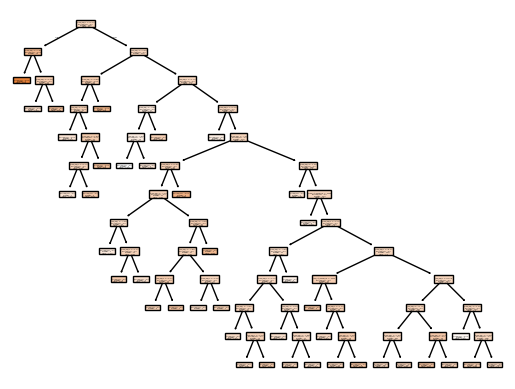

In [49]:
from sklearn.tree import plot_tree
plot_tree(first_tree, feature_names=X_train_trad.columns, filled=True)

In [50]:
from sklearn.tree import export_graphviz
export_graphviz(first_tree, out_file='tree.dot',feature_names=X_train_trad.columns, filled=True, rounded=True)

Graphviz not found. Install it with:
Windows: pip install graphviz and download from https://graphviz.org/download/
Linux: sudo apt-get install graphviz
Mac: brew install graphviz


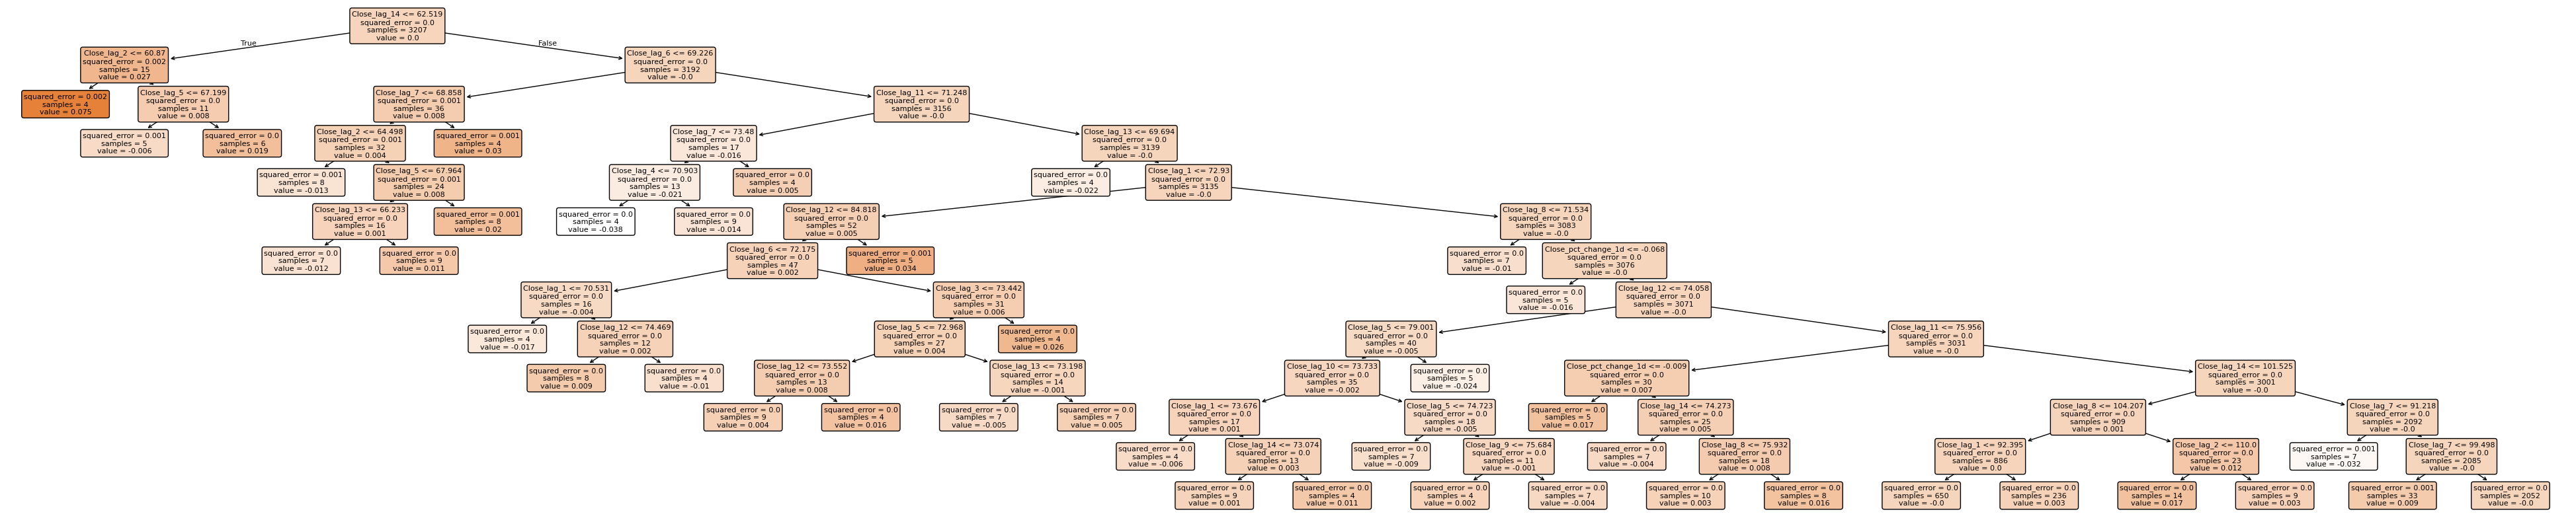

In [56]:
try:
	from subprocess import call
	call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
	from IPython.display import Image
	display(Image(filename='tree.png'))
except FileNotFoundError:
	print("Graphviz not found. Install it with:")
	print("Windows: pip install graphviz and download from https://graphviz.org/download/")
	print("Linux: sudo apt-get install graphviz")
	print("Mac: brew install graphviz")
	
	# Alternative: Display tree using matplotlib
	import matplotlib.pyplot as plt
	from sklearn.tree import plot_tree
	plt.figure(figsize=(50, 10))
	plot_tree(first_tree, feature_names=X_train_trad.columns, filled=True, rounded=True, fontsize=8)
	plt.show()

In [62]:
best_params_xgb

{'gamma': 0,
 'learning_rate': 0.001,
 'max_depth': 10,
 'n_estimators': 100,
 'random_state': 42,
 'reg_alpha': 0.01,
 'reg_lambda': 0.1}